Welcome to Machine Learning!

In [1]:
import sys
assert sys.version_info >= (3, 7)
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse('1.0.1')
import pandas as pd
import numpy as np

额外的代码，和本节内容无关，主要是用于保存图片

In [2]:
img_path = '../Tex/img/codes/'
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = img_path + f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
housing = pd.read_csv('data/housing.csv')

In [4]:
housing.sample(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
8581     -118.38     34.05                52.0       1004.0           231.0   
12760    -116.97     32.78                37.0       1255.0           238.0   
12633    -118.30     33.72                28.0       2510.0           583.0   
147      -117.94     34.06                32.0       3418.0           662.0   
6189     -117.77     34.12                15.0       4260.0           770.0   

       population  households  median_income  median_house_value  \
8581        590.0       226.0         4.2404            351000.0   
12760       671.0       278.0         3.7019            138600.0   
12633      1388.0       554.0         3.3397            267800.0   
147        2003.0       622.0         4.0333            210200.0   
6189       2007.0       695.0         4.4609            230000.0   

      ocean_proximity  
8581        <1H OCEAN  
12760       <1H OCEAN  
12633      NEAR OCEAN  
147         <1H OCEAN  
6189           INLAND

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# housing.describe()
housing.describe().transpose()

count           mean            std         min  \
longitude           20640.0    -119.569704       2.003532   -124.3500   
latitude            20640.0      35.631861       2.135952     32.5400   
housing_median_age  20640.0      28.639486      12.585558      1.0000   
total_rooms         20640.0    2635.763081    2181.615252      2.0000   
total_bedrooms      20433.0     537.870553     421.385070      1.0000   
population          20640.0    1425.476744    1132.462122      3.0000   
households          20640.0     499.539680     382.329753      1.0000   
median_income       20640.0       3.870671       1.899822      0.4999   
median_house_value  20640.0  206855.816909  115395.615874  14999.0000   

                            25%          50%           75%          max  
longitude             -121.8000    -118.4900    -118.01000    -114.3100  
latitude                33.9300      34.2600      37.71000      41.9500  
housing_median_age      18.0000      29.0000      37.00000      52.0000  
total_rooms           1447.7500    2127.0000    3148.00000   39320.0000  
total_bedrooms         296.0000     435.0000     647.00000    6445.0000  
population             787.0000    1166.0000    1725.00000   35682.0000  
households             280.0000     409.0000     605.00000    6082.0000  
median_income            2.5634       3.5348       4.74325      15.0001  
median_house_value  119600.0000  179700.0000  264725.00000  500001.0000

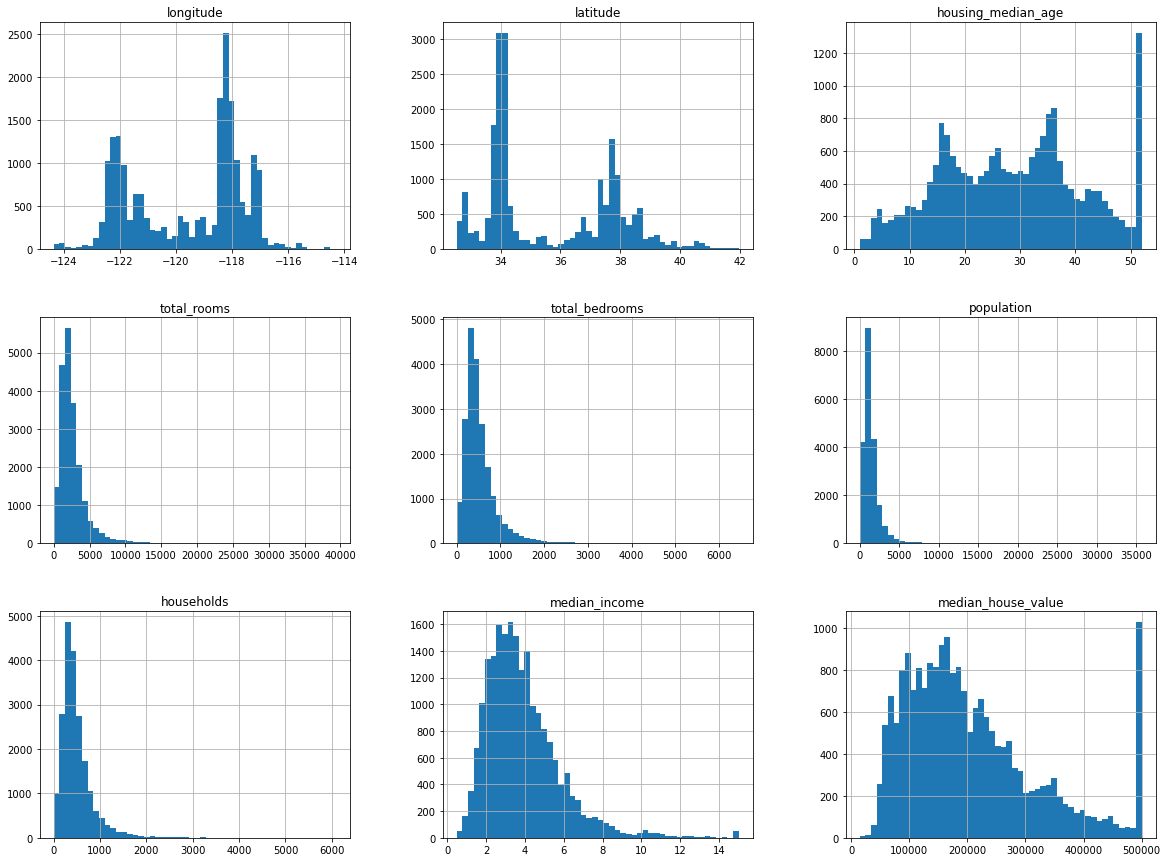

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [9]:
import numpy as np
def split_train_test(data, test_ratio):
    # np.random.seed(39)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[: test_set_size]
    train_indices = shuffled_indices[test_set_size: ]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, .2)
len(train_set), len(test_set)
# (16512, 4128)

(16512, 4128)

In [10]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, .2, 'index')
len(train_set), len(test_set)
# (16512, 4128)

(16512, 4128)

In [11]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, .2, 'id')
len(train_set), len(test_set)

(16322, 4318)

In [12]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=.2, random_state=42)
len(train_set), len(test_set)
(16512, 4128)

(16512, 4128)

In [13]:
from scipy.stats import binom
sample_size = 1000
ratio_female = 0.513
# female less than 485
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
# female more than 535
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.11294380139035697


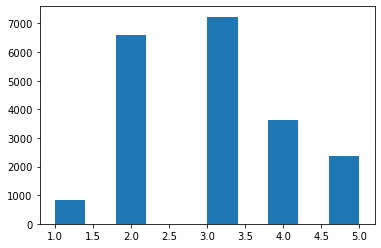

In [14]:
housing['income_cat'] = pd.cut(housing['median_income'],
                                bins=[0, 1.5, 3.0, 4.5, 6, np.inf], 
                                labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist(grid=False)
plt.show()

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [16]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [17]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)
train_set, test_set = train_test_split(housing, test_size=.2, random_state=42)
compare_props = pd.DataFrame({
    'Overall %': income_cat_proportions(housing),
    'Stratifies %': income_cat_proportions(strat_test_set),
    'Random %': income_cat_proportions(test_set)
    }
).sort_index()
compare_props.index.name = 'Income Category'
compare_props['Strat. Error %'] = (compare_props['Stratifies %'] / compare_props['Overall %'] - 1)
compare_props['Rand. Error %'] = (compare_props['Random %'] / compare_props['Overall %'] - 1)
(100 * compare_props).round(2)

Overall %  Stratifies %  Random %  Strat. Error %  \
Income Category                                                      
1                     3.98          4.00      4.24            0.36   
2                    31.88         31.88     30.74           -0.02   
3                    35.06         35.05     34.52           -0.01   
4                    17.63         17.64     18.41            0.03   
5                    11.44         11.43     12.09           -0.08   

                 Rand. Error %  
Income Category                 
1                         6.45  
2                        -3.59  
3                        -1.53  
4                         4.42  
5                         5.63

In [18]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis='columns', inplace=True)

In [19]:
housing = strat_train_set.copy()

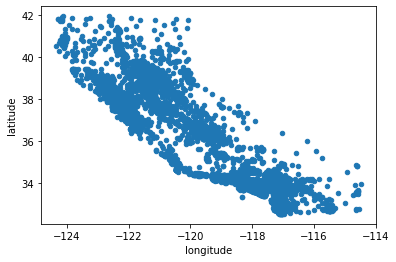

In [20]:
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()

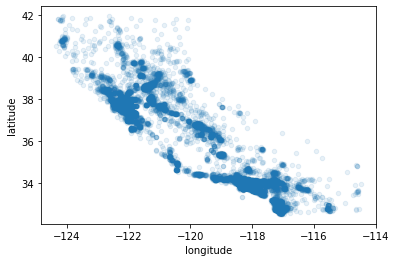

In [21]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=.1)
plt.show()

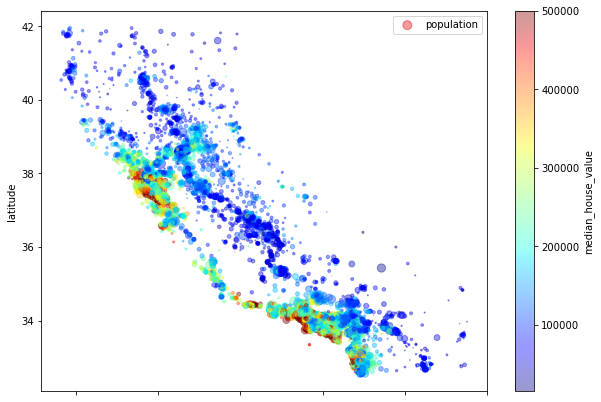

In [22]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=.4, s=housing['population'] / 100,
             label='population', figsize=(10, 7),
             c='median_house_value', cmap='jet', colorbar=True)
plt.legend()
plt.show()

In [23]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

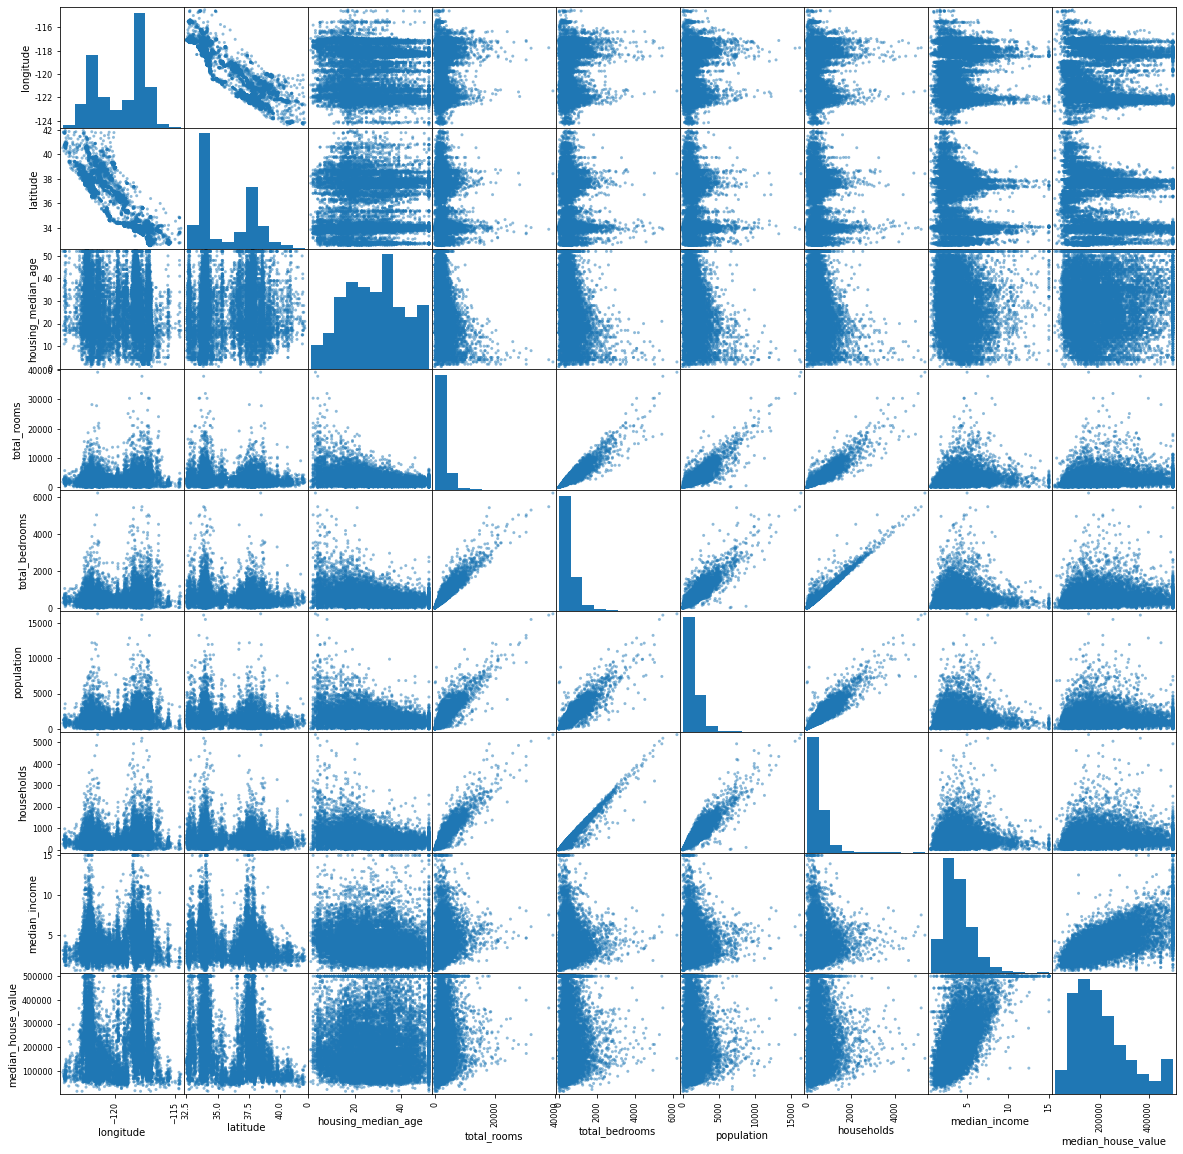

In [24]:
from pandas.plotting import scatter_matrix
scatter_matrix(housing, figsize=(20, 20))
plt.show()

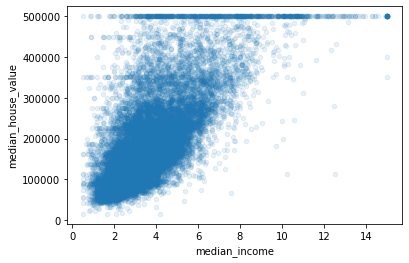

In [25]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=.1)
plt.show()

In [26]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [27]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

In [28]:
housing = strat_train_set.drop('median_house_value', axis='columns')
housing_labels = strat_train_set['median_house_value'].copy()

In [29]:
housing.dropna(subset=['total_bedrooms'])

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   
...          ...       ...                 ...          ...             ...   
14207    -118.40     33.86                41.0       2237.0           597.0   
13105    -119.31     36.32                23.0       2945.0           592.0   
19301    -117.06     32.59                13.0       3920.0           775.0   
19121    -118.40     34.06                37.0       3781.0           873.0   
19888    -122.41     37.66                44.0        431.0           195.0   

       population  households  median_income ocean_proximity  
13096      1576.0      1034.0         2.0987        NEAR BAY  
14973       666.0       357.0         6.0876       <1H OCEAN  
3785        562.0       203.0         2.4330          INLAND  
14689      1845.0       780.0         2.2618          INLAND  
20507      1912.0      1172.0         3.5292      NEAR OCEAN  
...           ...         ...            ...             ...  
14207       938.0       523.0         4.7105       <1H OCEAN  
13105      1419.0       532.0         2.5733          INLAND  
19301      2814.0       760.0         4.0616      NEAR OCEAN  
19121      1725.0       838.0         4.1455       <1H OCEAN  
19888       682.0       212.0         3.2833      NEAR OCEAN  

[16344 rows x 9 columns]

In [30]:
from sklearn.impute import SimpleImputer

In [31]:
imputer = SimpleImputer(strategy='median')

In [32]:
housing_num = housing.drop('ocean_proximity', axis='columns')

In [33]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [34]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [35]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [36]:
X = imputer.transform(housing_num)

In [37]:
housing_tr = pd.DataFrame(X,
                          columns=housing_num.columns,
                          index=housing_num.index)

In [38]:
housing_tr

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   
...          ...       ...                 ...          ...             ...   
14207    -118.40     33.86                41.0       2237.0           597.0   
13105    -119.31     36.32                23.0       2945.0           592.0   
19301    -117.06     32.59                13.0       3920.0           775.0   
19121    -118.40     34.06                37.0       3781.0           873.0   
19888    -122.41     37.66                44.0        431.0           195.0   

       population  households  median_income  
13096      1576.0      1034.0         2.0987  
14973       666.0       357.0         6.0876  
3785        562.0       203.0         2.4330  
14689      1845.0       780.0         2.2618  
20507      1912.0      1172.0         3.5292  
...           ...         ...            ...  
14207       938.0       523.0         4.7105  
13105      1419.0       532.0         2.5733  
19301      2814.0       760.0         4.0616  
19121      1725.0       838.0         4.1455  
19888       682.0       212.0         3.2833  

[16512 rows x 8 columns]

# Handling Text and Categorical Attributes

In [39]:
housing_cat = housing[["ocean_proximity"]]

In [40]:
housing_cat.head(10)

ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN
1286           INLAND
18078       <1H OCEAN
4396         NEAR BAY
18031       <1H OCEAN
6753        <1H OCEAN

In [41]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [42]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [43]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [44]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [45]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [46]:
from sklearn.preprocessing import MinMaxScaler

min_max_scalar = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scalar.fit_transform(housing_num)
pd.DataFrame(housing_num_min_max_scaled).sample(3)

0        1         2         3         4         5         6  \
6939   0.255578 -0.56383 -0.843137 -0.629076 -0.633435 -0.617225 -0.653164   
7261  -0.576065  0.16383 -0.843137 -0.804466 -0.747141 -0.748497 -0.733060   
10638  0.245436 -0.57234 -0.568627 -0.874358 -0.868900 -0.871795 -0.858503   

              7  
6939  -0.380629  
7261  -0.372781  
10638 -0.419346

In [47]:
from sklearn.preprocessing import StandardScaler
std_scalar = StandardScaler()
housing_num_std_scalar = std_scalar.fit_transform(housing_num)
pd.DataFrame(housing_num_std_scalar).sample(3)

0         1         2         3         4         5         6  \
1784   0.751351 -0.861486  0.430885  0.387419 -0.075378 -0.104602  0.007862   
15821 -1.318066  0.863599  0.828172 -0.505396 -0.469387 -0.202340 -0.339529   
8531  -0.838201  1.421438 -1.158263  1.608806  1.167989  0.896529  1.151900   

              7  
1784   1.718753  
15821 -0.540324  
8531   0.188052

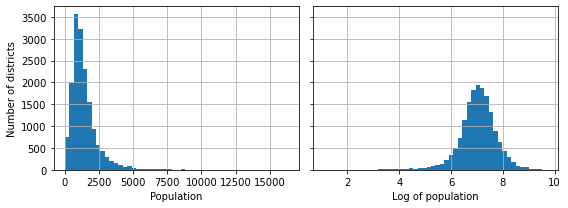

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing['population'].hist(ax=axs[0], bins=50)
housing['population'].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel('Population')
axs[1].set_xlabel('Log of population')
axs[0].set_ylabel('Number of districts')
save_fig('Transforming a feature to make it closer to a Gaussian distribution')
plt.show()

额外的代码

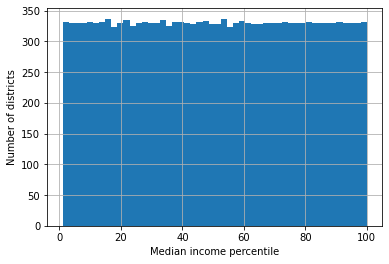

In [49]:
percentiles = [np.percentile(housing.median_income, p) for p in range(1, 100)] 
flattened_median_income = pd.cut(housing.median_income,
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

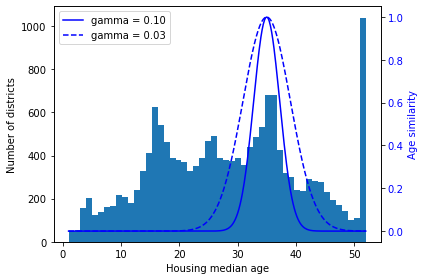

In [50]:
from sklearn.metrics.pairwise import rbf_kernel

# 更一般的情况，是向量与向量之间的RBF，因此需要使用DataFrame
age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=.1)

ages = np.linspace(housing['housing_median_age'].min(),
                   housing['housing_median_age'].max(),
                   500).reshape(-1, 1)
gamma1 = .1
gamma2 = .03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Housing median age')
ax1.set_ylabel('Number of districts')
ax1.hist(housing['housing_median_age'], bins=50)

ax2 = ax1.twinx()
color = 'blue'
ax2.plot(ages, rbf1, color=color, label='gamma = 0.10')
ax2.plot(ages, rbf2, color=color, label='gamma = 0.03', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Age similarity', color=color)
plt.legend()

save_fig('Gaussian RBF feature measuring the similarity')
plt.show()

In [51]:
from sklearn.linear_model import LinearRegression

target_scalar = StandardScaler()
scaled_labels = target_scalar.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
# pretend this is new data
some_new_data = housing[['median_income']].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scalar.inverse_transform(scaled_predictions)
# predictions.flatten()

In [52]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predictions = model.predict(some_new_data)

predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformers

Let’s create a log-transformer and apply it to the population feature:

In [53]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])

In [54]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35]], gamma=.1))
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [55]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=.1))

sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [56]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1, 2], [3, 4], [5, 6], [6, 7]]))

array([[0.5       ],
       [0.75      ],
       [0.83333333],
       [0.85714286]])

Here’s a custom transformer that acts much like the StandardScaler:

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean
        
    def fit(self, X, y=None):
        X = check_array(X)
        self.mean_ = X.mean(axis='index')
        self.scale_ = X.std(axis='index')
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [58]:
# 如果在这里出现问题，需要检查numpy的版本
# 极大可能是因为numpy的版本问题
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=90, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f'Cluster {i} similarity' for i in range(self.n_clusters)]

In [59]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']], sample_weight=housing_labels)

In [60]:
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

额外的代码

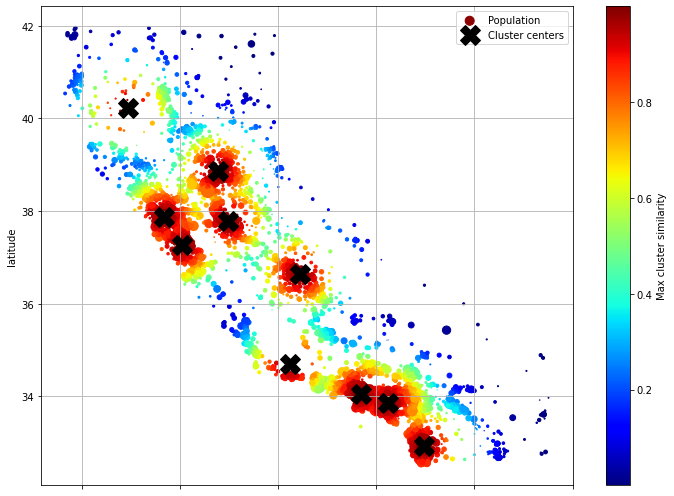

In [61]:
housing_copy = housing.copy()
housing_copy['Max cluster similarity'] = similarities.max(axis=1)

housing_copy.plot(kind='scatter', x='longitude', y='latitude', grid=True,
                  s=housing_copy['population'] / 100, label='Population',
                  c='Max cluster similarity',
                  cmap='jet', colorbar=True,
                  legend=True, sharex=True, figsize=(10, 7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle='', color='black', marker='X', markersize=20,
         label='Cluster centers')
plt.legend(loc='upper right')
save_fig('Gaussian RBF similarity to the nearest cluster center')
plt.show()

### Transformation Pipelines


不知道为什么，这里需要重新加载以下代码：
```python
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
```

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])


In [63]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [64]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[: 2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [65]:
# 如果没有必要的话，这段代码不需要看
def monkey_patch_get_signature_names_out():
    """
    Monkey patch some classes which did not handle get_feature_names_out()
    correctly in Scikit-Learn 1.0.*. 
    """
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler
    
    default_get_feature_names_out = StandardScaler.get_feature_names_out
    if not hasattr(SimpleImputer, 'get_feature_names_out'):
        print('Monkey-patching SimpleImputer.get_feature_names_out()')
        SimpleImputer.get_feature_names_out = default_get_feature_names_out
        
    if not hasattr(FunctionTransformer, 'get_feature_names_out'):
        print('Monkey-patching FunctionTransformer.get_feature_names_out()')
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)
        
        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out
            
            
        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter('feature_names_out', Parameter.KEYWORD_ONLY)
            ]
        )
        
        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == 'one-to-one'
            return default_get_feature_names_out(self, names)
        
        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out
        
monkey_patch_get_signature_names_out()  

Monkey-patching SimpleImputer.get_feature_names_out()
Monkey-patching FunctionTransformer.get_feature_names_out()


In [66]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared,
    columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
)

In [67]:
df_housing_num_prepared.head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -1.423037  1.013606            1.861119     0.311912        1.368167   
14973   0.596394 -0.702103            0.907630    -0.308620       -0.435925   
3785   -1.203098  1.276119            0.351428    -0.712240       -0.760709   

       population  households  median_income  
13096    0.137460    1.394812      -0.936491  
14973   -0.693771   -0.373485       1.171942  
3785    -0.788768   -0.775727      -0.759789

In [68]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [69]:
num_pipeline[1]

StandardScaler()

In [70]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [71]:
num_pipeline.named_steps['simpleimputer']

SimpleImputer(strategy='median')

In [72]:
num_pipeline.set_params(simpleimputer__strategy='median')

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [73]:
from sklearn.compose import ColumnTransformer

num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
               'total_bedrooms', 'population', 'households', 'median_income']

cat_attribs = ['ocean_proximity']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [74]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

In [75]:
housing_prepared = preprocessing.fit_transform(housing)

In [76]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index
)
housing_prepared_fr.head(2)

pipeline-1__longitude  pipeline-1__latitude  \
13096              -1.423037              1.013606   
14973               0.596394             -0.702103   

       pipeline-1__housing_median_age  pipeline-1__total_rooms  \
13096                        1.861119                 0.311912   
14973                        0.907630                -0.308620   

       pipeline-1__total_bedrooms  pipeline-1__population  \
13096                    1.368167                0.137460   
14973                   -0.435925               -0.693771   

       pipeline-1__households  pipeline-1__median_income  \
13096                1.394812                  -0.936491   
14973               -0.373485                   1.171942   

       pipeline-2__ocean_proximity_<1H OCEAN  \
13096                                    0.0   
14973                                    1.0   

       pipeline-2__ocean_proximity_INLAND  pipeline-2__ocean_proximity_ISLAND  \
13096                                 0.0                                 0.0   
14973                                 0.0                                 0.0   

       pipeline-2__ocean_proximity_NEAR BAY  \
13096                                   1.0   
14973                                   0.0   

       pipeline-2__ocean_proximity_NEAR OCEAN  
13096                                     0.0  
14973                                     0.0

In [77]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ['ratio']

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )
    
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                      StandardScaler())

preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', ratio_pipeline(), ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline(), ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population', 
                             'households', 'median_income']),
    ('geo', cluster_simil, ['latitude', 'longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))
],
                                  remainder=default_num_pipeline)

In [78]:
housing_prepared = preprocessing.fit_transform(housing)

In [79]:
pd.DataFrame(
    housing_prepared, 
    columns=preprocessing.get_feature_names_out(),
    index=housing.index).head(3)

bedrooms__ratio  rooms_per_house__ratio  people_per_house__ratio  \
13096         1.846624               -0.866027                -0.330204   
14973        -0.508121                0.024550                -0.253616   
3785         -0.202155               -0.041193                -0.051041   

       log__total_bedrooms  log__total_rooms  log__population  \
13096             1.324114          0.637892         0.456906   
14973            -0.252671         -0.063576        -0.711654   
3785             -0.925266         -0.859927        -0.941997   

       log__households  log__median_income  geo__Cluster 0 similarity  \
13096         1.310369           -1.071522               3.788947e-18   
14973        -0.142030            1.194712               3.346712e-01   
3785         -0.913030           -0.756981               2.874903e-18   

       geo__Cluster 1 similarity  ...  geo__Cluster 6 similarity  \
13096               1.319640e-01  ...               3.398866e-24   
14973               1.735776e-09  ...               2.706351e-02   
3785                2.749482e-01  ...               1.020912e-24   

       geo__Cluster 7 similarity  geo__Cluster 8 similarity  \
13096               9.698809e-01               7.073518e-08   
14973               8.786936e-14               1.275435e-01   
3785                7.483836e-01               1.871204e-08   

       geo__Cluster 9 similarity  cat__ocean_proximity_<1H OCEAN  \
13096               5.824761e-01                             0.0   
14973               2.078829e-10                             1.0   
3785                2.896858e-01                             0.0   

       cat__ocean_proximity_INLAND  cat__ocean_proximity_ISLAND  \
13096                          0.0                          0.0   
14973                          0.0                          0.0   
3785                           1.0                          0.0   

       cat__ocean_proximity_NEAR BAY  cat__ocean_proximity_NEAR OCEAN  \
13096                            1.0                              0.0   
14973                            0.0                              0.0   
3785                             0.0                              0.0   

       remainder__housing_median_age  
13096                       1.861119  
14973                       0.907630  
3785                        0.351428  

[3 rows x 24 columns]

In [80]:
housing_prepared.shape

(16512, 24)

In [81]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Select and Train a Model

## Train and Evaluate on the Training Set

In [82]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())

lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(gamma=1,
                                                                    n_clusters=10,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E007ACD700>)])),
                ('linearregression', LinearRegression())])

In [83]:
housing_prediction = lin_reg.predict(housing)
print(housing_prediction[:5].round(-2))
# -2 = rounded to the nearest hundred
print(housing_labels.iloc[: 5].values)

[243700. 372400. 128800.  94400. 328300.]
[458300. 483800. 101700.  96100. 361800.]


In [84]:
from sklearn.metrics import mean_squared_error
# rmse: root mean squared error
line_rmse = mean_squared_error(housing_labels, 
                               housing_prediction,
                               squared=False)
line_rmse

68687.89176590189

In [85]:
# extra code
error_ratios = housing_prediction[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(', '.join([f'{100 * ratio:.1f}%' for ratio in error_ratios]))

-46.8%, -23.0%, 26.6%, -1.8%, -9.3%


In [86]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                                    n_clusters=10,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E007ACD700>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [87]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(
    housing_labels,
    housing_predictions,
    squared=False
)
tree_rmse

0.0

In [88]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring='neg_root_mean_squared_error',
                              cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

In [89]:
# extra code – computes the error stats for the linear model
lin_rmses = - cross_val_score(lin_reg, housing, housing_labels, 
                              scoring='neg_root_mean_squared_error',
                              cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64

In [90]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = - cross_val_score(forest_reg, 
                                 housing, 
                                 housing_labels,
                                 scoring='neg_root_mean_squared_error',
                                 cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64

In [91]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels,
                                 housing_predictions,
                                 squared=False)
forest_rmse

17474.619286483998

# Fine-Tune Your Model

## Grid Search

In [92]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42))
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001E007ACD700>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [93]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

Since 15 is the maximum value that was evaluated for n_clusters, you should probably try searching again with higher values; the score may continue to improve.

In [94]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_res = cv_res[['param_preprocessing__geo__n_clusters',
                 'param_random_forest__max_features',
                 'split0_test_score',
                 'split1_test_score',
                 'split2_test_score',
                 'mean_test_score']]
score_cols = ['split0', 'split1', 'split2', 'mean_test_rmse']
cv_res.columns = ['n_clusters', 'max_features'] + score_cols
cv_res[score_cols] = - cv_res[score_cols].round().astype(np.int64)
cv_res.head()

n_clusters max_features  split0  split1  split2  mean_test_rmse
12         15            6   43460   43919   44748           44042
13         15            8   44132   44075   45010           44406
14         15           10   44374   44286   45316           44659
7          10            6   44683   44655   45657           44999
9          10            6   44683   44655   45657           44999

## Randomized Search

In [95]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'preprocessing__geo__n_clusters': randint(low=3, high=50),
    'random_forest__max_features': randint(low=2, high=20)
}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42
)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001E007ACD700>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E008061610>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E00807AF10>},
                   random_state=42, scoring='neg_root_mean_squared_error')

### 额外的代码

Here are plots of the probability mass functions (for discrete variables), and probability density functions (for continuous variables) for `randint()`, `uniform()`, `geom()` and `expon()`:

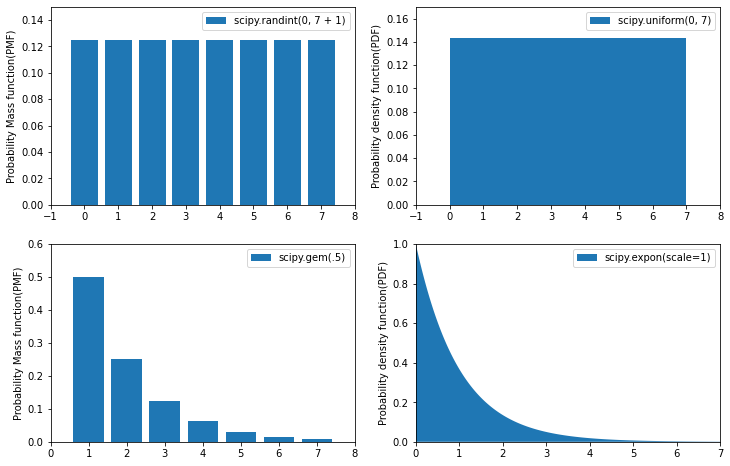

In [96]:
from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label='scipy.randint(0, 7 + 1)')
plt.ylabel('Probability Mass function(PMF)')
plt.legend()
plt.axis([-1, 8, 0, .15])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label='scipy.uniform(0, 7)')
plt.ylabel('Probability density function(PDF)')
plt.legend()
plt.axis([-1, 8, 0 , .17])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label='scipy.gem(.5)')
plt.ylabel('Probability Mass function(PMF)')
plt.legend()
plt.axis([0, 8, 0, .6])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label='scipy.expon(scale=1)')
plt.ylabel('Probability density function(PDF)')
plt.legend()
plt.axis([0, 7, 0, 1])
plt.show()

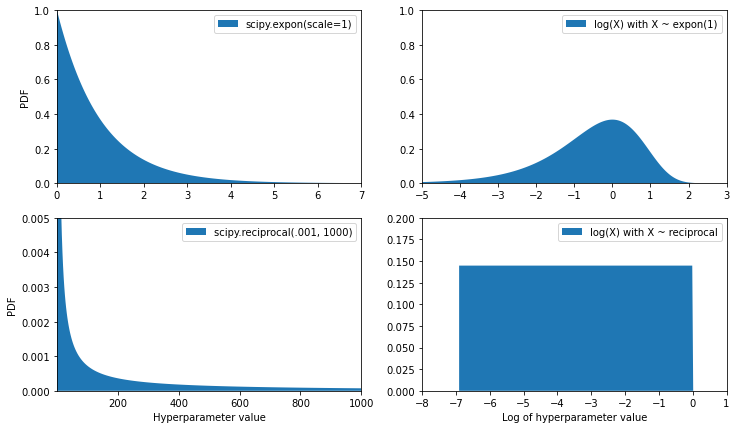

In [97]:
from scipy.stats import reciprocal

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(.001, 1000, 500)
reciprocal_distrib = reciprocal(.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(.001), np.log(1000), 500)
log_reciprocal_distrib = uniform(np.log(.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib, label='scipy.expon(scale=1)')
plt.ylabel('PDF')
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib, label='log(X) with X ~ expon(1)')
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, reciprocal_distrib, label='scipy.reciprocal(.001, 1000)')
plt.ylabel('PDF')
plt.xlabel('Hyperparameter value')
plt.legend()
plt.axis([.001, 1000, 0, .005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_reciprocal_distrib, label='log(X) with X ~ reciprocal')
plt.xlabel('Log of hyperparameter value')
plt.legend()
plt.axis([-8, 1, 0, .2])

plt.show()

设随机变量$X$有概率密度函数 $f(x)$, $x \in (a, b)$($a$, $b$ 可以为 $\infty$), 而 $y = g(x)$ 在 $x \in (a, b)$ 上是严格单调的连续函数，存在唯一的反函数$x =  y \in (\alpha, \beta)$ 并且 $h'(y)$ 存在且连续，那么 $Y = g(X)$ 也是连续型随机变量且有概率密度函数

$$p(y)=f(h(y))|h'(y)|$$

## Ensemble Methods

## Analyzing the Best Models and Their Errors

In [98]:
final_model = rnd_search.best_estimator_
feature_importances = final_model['random_forest'].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [99]:
sorted(zip(feature_importances,
           final_model['preprocessing'].get_feature_names_out()),
       reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms__ratio'),
 (0.05446998753775219, 'rooms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__Cluster 0 similarity'),
 (0.02879263999929514, 'geo__Cluster 28 similarity'),
 (0.023530192521380392, 'geo__Cluster 24 similarity'),
 (0.020544786346378206, 'geo__Cluster 27 similarity'),
 (0.019873052631077512, 'geo__Cluster 43 similarity'),
 (0.018597511022930273, 'geo__Cluster 34 similarity'),
 (0.017409085415656868, 'geo__Cluster 37 similarity'),
 (0.015546519677632162, 'geo__Cluster 20 similarity'),
 (0.014230331127504292, 'geo__Cluster 17 similarity'),
 (0.0141032216204026, 'geo__Cluster 39 similarity'),
 (0.014065768027447325, 'geo__Cluster 9 similarity'),
 (0.01354220782825315, 'geo__Cluster 4 similarity'),
 (0.013489636258229071, 'geo__Cluster 3 similarity'),
 (0.013383196263838682, 'geo__Cluster 38 similarit

## Evaluate Your System on the Test Set

In [100]:
X_test = strat_test_set.drop('median_house_value', axis='columns')
y_test = strat_test_set['median_house_value'].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

41424.40026462184

In [101]:
from scipy import stats
confidence = .95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39275.40861216, 43467.27680583])

也可以手动计算置信区间：

In [102]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(39275.40861216077, 43467.27680583419)

Alternatively, we could use a z-score rather than a t-score. Since the test set is not too small, it won't make a big difference:

In [103]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(39276.05610140007, 43466.69174996963)

# Launch, Monitor, and Maintain Your System

In [104]:
import joblib

joblib.dump(final_model, 'my_california_housing_model.pkl')

['my_california_housing_model.pkl']

In [105]:
import joblib

from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

final_model_reloaded = joblib.load('my_california_housing_model.pkl')

new_data = housing.iloc[: 5]
predictions = final_model_reloaded.predict(new_data)

In [106]:
predictions

array([442737.15, 457566.06, 105965.  ,  98462.  , 332992.01])

# Exercises solutions

Exercise1: Try a Support Vector Machine regressor (`sklearn.svm.SVR`) with various hyperparameters, such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Note that SVMs don't scale well to large datasets, so you should probably train your model on just the first 5,000 instances of the training set and use only 3-fold cross-validation, or else it will take hours. Don't worry about what the hyperparameters mean for now (see the SVM notebook if you're interested). How does the best `SVR` predictor perform?

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [{
    'svr__kernel': ['linear'],
    'svr__C': [10, 30, 100, 300, 1000, 3000, 10000, 30000]
}, {
    'svr__kernel': ['rbf'],
    'svr__C': [1, 3, 10, 30, 100, 300, 1000],
    'svr__gamma': [.01, .0103, .1, .3, 1.0, 3.0]
}]

svr_pipeline = Pipeline([('preprocessing', preprocessing), ('svr', SVR())])

grid_search = GridSearchCV(svr_pipeline,
                           param_grid,
                           cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001E007ACD700>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10, 30, 100, 300, 1000, 3000, 10000,
                                     30000],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1, 3, 10, 30, 100, 300, 1000],
                          'svr__gamma': [0.01, 0.0103, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [108]:
svr_grid_search_rmse = - grid_search.best_score_
svr_grid_search_rmse

69814.13849439977

In [109]:
grid_search.best_params_

{'svr__C': 10000, 'svr__kernel': 'linear'}

Exercise2: Try replacing the `GridSearchCV` with a `RandomizedSearchCV`.

In [110]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': reciprocal(20, 200_000),
    'svr__gamma': expon(scale=1.0)
}

rnd_search = RandomizedSearchCV(svr_pipeline,
                                param_distributions=param_distribs,
                                n_iter=50,
                                cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing.iloc[: 5000], housing_labels.iloc[: 5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001E007ACD700>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E0089070A0>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E0077AFC40>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [111]:
svr_rnd_search_rmse = - rnd_search.best_score_
svr_rnd_search_rmse

55853.88100674035

Now that's really much better, but still far from the RandomForestRegressor's performance. Let's check the best hyperparameters found:

In [112]:
rnd_search.best_params_

{'svr__C': 157055.10989448498,
 'svr__gamma': 0.26497040005002437,
 'svr__kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Note that we used the expon() distribution for gamma, with a scale of 1, so RandomSearch mostly searched for values roughly of that scale: about 80% of the samples were between 0.1 and 2.3 (roughly 10% were smaller and 10% were larger):

In [113]:
np.random.seed(42)

s = expon(scale=1).rvs(100_000)

((s > .105) & (s < 2.29)).sum() / len(s)

0.80066

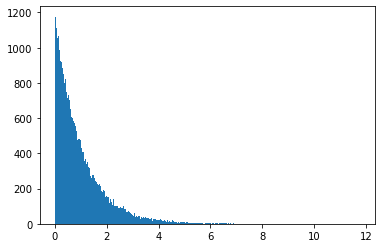

In [114]:
plt.hist(s, bins=1000)
plt.show()

We used the `reciprocal()` distribution for `C`, meaning we did not have a clue what the optimal scale of `C` was before running the random search. It explored the range from 20 to 200 just as much as the range from 2,000 to 20,000 or from 20,000 to 200,000.

Exercise3: Try adding a SelectFromModel transformer in the preparation pipeline to select only the most important attributes.

In [115]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector',
     SelectFromModel(RandomForestRegressor(random_state=42), threshold=.005)),
    ('svr',
     SVR(C=rnd_search.best_params_['svr__C'],
         gamma=rnd_search.best_params_['svr__gamma'],
         kernel=rnd_search.best_params_['svr__kernel']))
])

In [116]:
selector_rmses = -cross_val_score(selector_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels[:5000],
                                  scoring='neg_root_mean_squared_error',
                                  cv=3)
pd.Series(selector_rmses).describe()

count        3.000000
mean     56211.362089
std       1922.002815
min      54150.008611
25%      55339.929911
50%      56529.851212
75%      57242.038828
max      57954.226445
dtype: float64

Oh well, feature selection does not seem to help. But maybe that's just because the threshold we used was not optimal. Perhaps try tuning it using random search or grid search?

Exercise4: Try creating a custom transformer that trains a k-Nearest Neighbors regressor (`sklearn.neighbors.KNeighborsRegressor`) in its `fit()` method, and outputs the model's predictions in its `transform()` method. Then add this feature to the preprocessing pipeline, using latitude and longitude as the inputs to this transformer. This will add a feature in the model that corresponds to the housing median price of the nearest districts.

Rather than restrict ourselves to k-Nearest Neighbors regressors, let's create a transformer that accepts any regressor. For this, we can extend the `MetaEstimatorMixin` and have a required `estimator` argument in the constructor. The `fit()` method must work on a clone of this estimator, and it must also save `feature_names_in_`. The `MetaEstimatorMixin` will ensure that `estimator` is listed as a required parameters, and it will update `get_params()` and `set_params()` to make the estimator's hyperparameters available for tuning. Lastly, we create a `get_feature_names_out()` method: the output column name is the ...

In [129]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import MetaEstimatorMixin, clone


class FeatureFromRegressor(MetaEstimatorMixin, BaseEstimator,
                           TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None):
        estimator_ = clone(self.estimator)
        estimator_.fit(X, y)
        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_
        if hasattr(self.estimator, 'feature_name_in'):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self

    def transform(self, X):
        check_is_fitted(self)
        predictions = self.estimator_.predict(X)
        if predictions.ndim == 1:
            predictions = predictions.reshape(-1, 1)
        return predictions

    def get_feature_name_out(self, names=None):
        check_is_fitted(self)
        n_outputs = getattr(self.estimator_, 'n_outputs_', 1)
        estimator_class_name = self.estimator_.__class__.__name__
        estimator_short_name = estimator_class_name.lower().replace('_', '')
        return [
            f'{estimator_short_name}_prediction_{i}' for i in range(n_outputs)
        ]

Let's ensure it complies to Scikit-Learn's API:

In [130]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(FeatureFromRegressor(KNeighborsRegressor()))

Good! Now let's test it:

In [131]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_transformer = FeatureFromRegressor(knn_reg)
geo_features = housing[['latitude', 'longitude']]
knn_transformer.fit_transform(geo_features, housing_labels)

array([[486100.66666667],
       [435250.        ],
       [105100.        ],
       ...,
       [148800.        ],
       [500001.        ],
       [234333.33333333]])

In [132]:
knn_transformer.get_feature_name_out()

['kneighborsregressor_prediction_0']

In [141]:
from sklearn.base import clone

transformers = [(name, clone(transformers), columns)
                for name, transformers, columns in preprocessing.transformers]

geo_index = [name for name, _, _ in transformers].index('geo')
transformers[geo_index] = ('geo', knn_transformer, ['latitude', 'longitude'])

new_geo_preprocessing = ColumnTransformer(transformers)
new_geo_preprocessing

ColumnTransformer(transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x000001E007BF88B0>,
                                                                      func=<function column_ratio at 0x000001E007BF8790>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_bedrooms', 'total_rooms']),
                                ('rooms_per_hou...
                                  'households', 'median_income']),
                                ('geo',
                                 FeatureFromRegressor(estimator=KNeighborsRegressor(n_neighbors=3,
                                                                                    weights='distance')),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001E007ACD700>)])

In [143]:
new_geo_pipeline = Pipeline([
    ('preprocessing', new_geo_preprocessing),
    ('svr', SVR(C=rnd_search.best_params_['svr__C'],
               gamma=rnd_search.best_params_['svr__gamma'],
               kernel=rnd_search.best_params_['svr__kernel']))
])

In [145]:
new_pipe_rmses = -cross_val_score(
    new_geo_pipeline,
    housing.iloc[:5_000],
    housing_labels[:5_000],
    scoring='neg_root_mean_squared_error',
    cv=3
)
pd.Series(new_pipe_rmses).describe()

count         3.000000
mean     105035.424251
std        2918.405323
min      101812.917595
25%      103802.984465
50%      105793.051334
75%      106646.677579
max      107500.303823
dtype: float64

Exercise5: Automatically explore some preparation options using RandomSearchCV.

In [147]:
param_distribs = {
    'preprocessing__geo__estimator__n_neighbors': range(1, 30),
    'preprocessing__geo__estimator__weights': ['distance', 'uniform'],
    'svr__C': reciprocal(20, 200_000),
    'svr__gamma': expon(scale=1.0)
}

new_geo_rnd_search = RandomizedSearchCV(new_geo_pipeline,
                                        param_distribs,
                                        n_iter=50,
                                        cv=3,
                                        scoring='neg_root_mean_squared_error',
                                        random_state=42)

new_geo_rnd_search.fit(housing.iloc[:5_000], housing_labels.iloc[:5_000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name at 0x000001E007BF88B0>,
                                                                                                                    func=<function column_ratio at 0x000001E007BF8790>)),
                                                                                               ('standardscaler',
                                                                                                St...
                   param_distributions={'preprocessing__geo__estimator__n_neighbors': range(1, 30),
                                        'preprocessing__geo__estimator__weights': ['distance',
                                                                                   'uniform'],
                                        'svr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E0471E2340>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E0471E86A0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [151]:
new_geo_rnd_search_rmse = -new_geo_rnd_search.best_score_
new_geo_rnd_search_rmse

106867.28959315516

Exercise6: Try to implement the `StandardScalerClone` class again from scratch, then add support for the `inverse_transform()` method: executing `scaler.inverse_transform(scaler.fit_transform(X))` should return an array very close to `X`. Then add support for feature names: set `feature_names_in_` in the `fit()` method if the input is a DataFrame. This attribute should be a NumPy array of column names. Lastly, implement the `get_feature_names_out()` method: it should have one optional `input_features=None` argument. If passed, the method should check that its length matches `n_features_in_`, and it should match `feature_names_in_` if it is defined, then `input_features` should be returned. If `input_features` is `None`, then the method should return `feature_names_in_` if it is defined or `np.array(["x0", "x1", ...])` with length `n_features_in_` otherwise.

In [180]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted


class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):
        X_orig = X
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        if hasattr(X_orig, 'columns'):
            self.feature_names_in_ = np.array(X_orig.columns, dtype=object)
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError('Unexpected number of features')
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

    def inverse_transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError('Unexpected number of features')
        X = X * self.scale_
        return X + self.mean_ if self.with_mean else X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return getattr(self, 'feature_names_in',
                           [f"x{i}" for i in range(self.n_features_in_)])
        else:
            if len(input_features) != self.n_features_in_:
                raise ValueError('Invalid number of features')
            if hasattr(self, 'feature_names_in_') and not np.all(
                    self.feature_names_in_ == input_features):
                raise ValueError('input_features not equal feature_names_in')
            return input_features

In [181]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(StandardScalerClone())

No errors, that's a great start, we respect the Scikit-Learn API.

Now let's ensure the transformation works as expected:

In [182]:
np.random.seed(42)

X = np.random.rand(1000, 3)

scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(X)
assert np.allclose(X_scaled, (X - X.mean(axis=0)) / X.std(axis=0))

In [183]:
scaler = StandardScalerClone()
X_back = scaler.inverse_transform(scaler.fit_transform(X))

assert np.allclose(X, X_back)

In [184]:
assert np.all(scaler.get_feature_names_out() == ['x0', 'x1', 'x2'])
assert np.all(scaler.get_feature_names_out(['a', 'b', 'c']) == ['a', 'b', 'c'])

And if we fit a DataFrame, are the feature in and out ok?

In [190]:
df = pd.DataFrame({'a': np.random.rand(100),
                  'b': np.random.rand(100)})
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

assert np.all(scaler.feature_names_in_ == ['a', 'b'])
assert np.all(scaler.get_feature_names_out() == ['a', 'b'])

All good! That's all for today! 😀